In [1]:
import scanpy as sc
import visium_stitcher as vs

Stitching together Visium samples is a two-step process. The first step is aligning the `hires` images from the spaceranger output of your individual slides in Fiji. Perform the following:

1. Open new project by clicking on File --> New --> TrakEM (blank)
2. Select folder containing hires Visium images found in the `spatial` output folder of spaceranger, make sure they have informative names that you can match to samples later
3. Right click on black canvas in Fiji and select Import. The selected folder will open and you can import the images you want to stitch
4. If the images don't fit the canvas, you can scale them down by selecting each image and then click on Image --> Scale --> modify values of scale in X and scale in Y to the desired fraction (e.g. 0.8)
5. Once the images are of the desired size, select them and right click to select Adjust images --> Blend (selected images) 
6. Select the image that you want to rotate and move around and right click to select Transform --> Transform (affine)
7. Rotate and move around the image as you wish and overlay it with the other image to obtain the desired combined image. Then right click to select Apply transform
8. Save as `.xml` by clicking File --> Save (.xml format is the default saving method)

Once armed in the `.xml` file produced by Fiji, along with one folder per sample holding the `raw_feature_bc_matrix.h5` and `spatial` outputs of spaceranger, you can create a joint object.

Start off by loading the transforms and inspecting them. By default, `vs.transform_finder()` will return a dictionary of the image paths used during the Fiji step, along with the corresponding transform. Take note of the image paths and their correspondence to spaceranger output that will be loaded shortly.

In [2]:
transforms = vs.transform_finder("demo_data/trial.xml")
transforms

{'WSSS_THYst9383362.png': array([[  1.,   0., 363.],
        [  0.,   1., 174.]]),
 'WSSS_THYst9383360.png': array([[-2.62489812e-01,  9.97094999e-01,  4.21616674e+02],
        [-9.67051525e-01, -2.54580730e-01,  1.75782464e+03]]),
 'WSSS_THYst9383361.png': array([[ 5.65211498e-01, -8.24946036e-01,  1.25342160e+03],
        [ 8.24946036e-01,  5.65211498e-01,  7.76485918e+02]])}

Load the spaceranger outputs for the two samples, and ensure the objects are concatenation-ready by storing the sample information (both in the `.obs_names` and an `.obs` column) and making the variable names unique. Please use the raw count matrices for accurate overlap evaluation, these can be trivially subset to filtered tissue spots later.

Our Fiji path images are named after the samples, which allows us to match them up easily to the data we're loading. Extract the transforms from the dictionary and store them in `.uns['transform']`, which is where `vs.stitcher()` needs them stored.

In [3]:
adata1 = sc.read_visium("demo_data/WSSS_THYst9383362", count_file="raw_feature_bc_matrix.h5")
adata1.var_names_make_unique()
adata1.obs_names = ["WSSS_THYst9383362-"+i for i in adata1.obs_names]
adata1.obs['sample'] = "WSSS_THYst9383362"
adata1.uns['transform'] = transforms["WSSS_THYst9383362.png"]

adata2 = sc.read_visium("demo_data/WSSS_THYst9383361", count_file="raw_feature_bc_matrix.h5")
adata2.var_names_make_unique()
adata2.obs_names = ["WSSS_THYst9383361-"+i for i in adata2.obs_names]
adata2.obs['sample'] = "WSSS_THYst9383361"
adata2.uns['transform'] = transforms["WSSS_THYst9383361.png"]

adata3 = sc.read_visium("demo_data/WSSS_THYst9383360", count_file="raw_feature_bc_matrix.h5")
adata3.var_names_make_unique()
adata3.obs_names = ["WSSS_THYst9383360-"+i for i in adata3.obs_names]
adata3.obs['sample'] = "WSSS_THYst9383360"
adata3.uns['transform'] = transforms["WSSS_THYst9383360.png"]

/home/jovyan/my-conda-envs/vs/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/vs/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/vs/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


At this point we can perform the stitching. The object order matters, as it will dictate the priority in taking the tissue image and spots in the event of an overlap.

At this point, it is safe to subset the object to the tissue spots. This can be done based on `.obs['in_tissue']`.

In [4]:
adata = vs.stitch([adata1, adata2, adata3])
adata = adata[adata.obs['in_tissue']==1]

`adata` is a functional Visium object storing both our samples, with the images and spots transformed accordingly to create a single joint entity.

/home/jovyan/my-conda-envs/vs/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


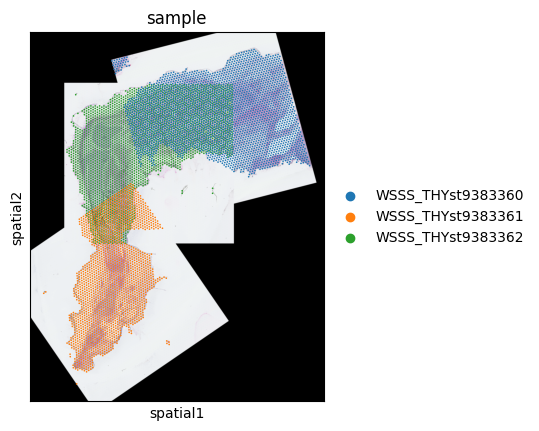

In [5]:
sc.pl.spatial(adata, color="sample")

Overlapping spots can be removed based on `.obs['overlap']`, giving priority to spots based on the order the objects were passed in to `vs.stitch()`.

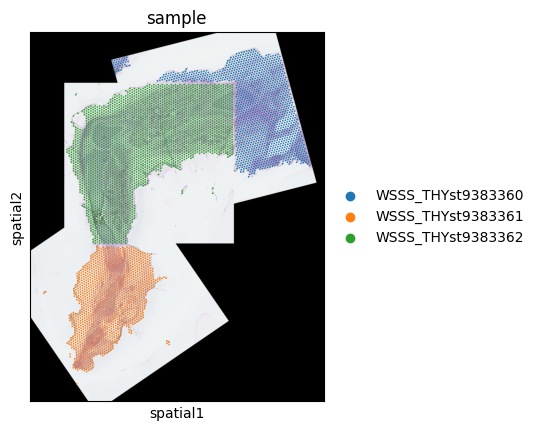

In [6]:
adata_nooverlap = adata[~adata.obs["overlap"]]
sc.pl.spatial(adata_nooverlap, color="sample")

You can provide a path to an image that you made in Fiji while aligning to use as the tissue image in the joint object.

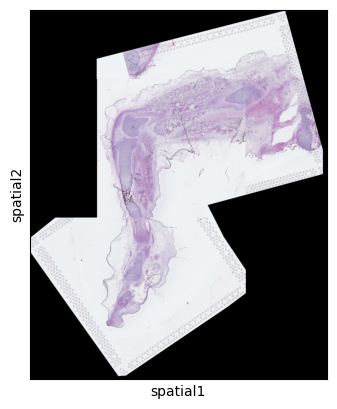

In [7]:
adata = vs.stitch([adata1, adata2, adata3], image="demo_data/tissue_hires_image.png")
sc.pl.spatial(adata)